## Import necessary modules

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import scipy as sci
import LabIFSC2 as lab
from LabIFSC2 import Medida,nominais
import typing

import os
import pathlib
plt.style.use("ggplot")

## Importar dados


Imports data and defines constants to parse the data

In [48]:
NUM_POINTS = 4096
SAMPLING_RATE = 50 # ms

def carregar_dados(path: str) -> np.ndarray:
  """
  Loads data from a csv file and returns a numpy array.

  Args:
    path: The full path to the csv file.

  Returns:
    A numpy array with the data.
  """
  df = pd.read_csv(path,sep=";")
  columns_to_remove = [df.columns[x] for x in [0,2,3,4]]
  df = df.drop(columns=[*columns_to_remove])[0:NUM_POINTS-1]
  df = df.rename(columns={df.columns[0]:"voltagem"})
  voltage_correction=1/2
  df["voltagem"] = df["voltagem"].map(lambda x: Medida(float(x.replace(",","."))*voltage_correction,"V", 0))
  array = df["voltagem"].to_numpy()
  return array - np.mean(array)

In [49]:
lambda_vermelho=Medida(632,"nm",0)
lambda_amarelo=Medida(594,"nm",0)
lambda_verde_harmonico=Medida(532,"nm",0)
lambda_verde=Medida(1064,"nm",0)
# Iterates through all csv files in "dados_interferometro_fft_dia_1" and imports
# the data to dados[filename]

dados: dict[str,pd.DataFrame] = {}
data_path=pathlib.Path(os.getcwd()).parent /"dados"/"segundo_dia"
for root, dirs, files in os.walk(data_path):
    print(files)
    for filename in files:
      if filename.endswith(".csv"):
        dados[filename] = carregar_dados(os.path.join(root, filename))

tempos = np.array([Medida(x*SAMPLING_RATE,"ms",0) for x in range(0,NUM_POINTS-1)])

[]
['vermelho.csv', 'vermelho.xlsm']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['vermelho+amarelo+verde.csv', 'vermelho+amarelo+verde.xlsm']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['verde.xlsm', 'verde.csv']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['vermelho+verde.xlsm', 'vermelho+verde.csv']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['amarelo_verde.xlsm', 'amarelo_verde.csv']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['vermelho+amarelo.csv', 'vermelho+amarelo.xlsm']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['amarelo.csv', 'amarelo.xlsm']


/tmp/ipykernel_3804/2698508843.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


## Fator de Calibração Laser Vermelho
Valor nominal: 632.8 nm

In [50]:
from numpy import argmax,arange
from numpy.fft import ifft

voltagens_laser_vermelho=nominais(dados["vermelho.csv"],"V")

dados_fft = abs(ifft(voltagens_laser_vermelho))
#os índices de dados_fft são proporcionais a frequência (f[n]=n x constante)
#convertendo em lambdas, temos que lambda = c/f,
#lambdas[n]=c/(n x constante) 
#podemos renomear c/constante como k
#lambdas[n]=k/n
indice_pico_laser_vermelho =argmax(dados_fft) +1 #213, adicionamos 1 pois 
# arrays em Python começam em 0

#podemos usar o laser vermelho como referência, 
#sabendo que o pico do laser vermelho é 632.8nm
#então, se ele ocorre no indice 213, temos que:
#k=lambda_vermelho x 213
k=indice_pico_laser_vermelho*lambda_vermelho

lambdas=k/arange(1,NUM_POINTS)

## Calculando a resolução da FFT ($\Delta \lambda$)

In [51]:
resolução_lambda=np.diff(lambdas)
for comprimento_de_onda in sorted([lambda_vermelho,lambda_amarelo,lambda_verde,lambda_verde_harmonico]):
  indice_mais_proximo=np.argmin(abs(comprimento_de_onda-lambdas))
  print(f"{comprimento_de_onda:E0}: {abs(resolução_lambda[indice_mais_proximo])}")

532 nm: 2,094799414895305744721554220 nm
594 nm: 2,600973800139058766944799572 nm
632 nm: 2,953271028037420364853460342 nm
1064 nm: 8,281003937007881177123636007 nm


## Gráficos

In [52]:
FIG_SIZE = (8,4)
DPI = 120

def translate_csv_name_to_literal(csv_name):
    translation_dict = {
        "vermelho.csv": "- Laser vermelho",
        "amarelo.csv": "- Laser amarelo",
        "verde.csv": "- Laser verde",
        "vermelho+verde.csv": "- Laser vermelho + verde",
        "vermelho+amarelo+verde.csv": "- Laser vermelho + amarelo + verde",
        "amarelo_verde.csv": "- Laser amarelo + verde",
        "vermelho+amarelo.csv": "- Laser vermelho + amarelo",
    }
    if csv_name not in translation_dict.keys():
        raise Exception(f"Can't translate CSV name to literal: {csv_name}.")
    return translation_dict[csv_name]

def grafico(
    nome_arquivo_csv:str,
    lambda_esperados:list[Medida]=[],
    lambda_medidos:list[typing.Tuple[Medida,Medida]]=[],
    time_interval:tuple[Medida,Medida]=[Medida(0,"s",0),Medida(5,"s",0)],
    lambda_interval:tuple[Medida,Medida]=[Medida(600,"nm",0),Medida(800,'nm',0)]
    ) -> typing.Tuple[plt.Figure,plt.Figure]:
    """
    Generates figures based on data, time_interval and lambda_interval.
    """

    unidade_voltagem = "V"
    unidade_tempo = "s"
    unidade_lambda = "nm"
    dpi = DPI
    # figure tempo
    fig_tempo, ax_tempo = plt.subplots(figsize=FIG_SIZE, dpi=dpi)
    # Assuming time_interval elements are Medida objects
    t_min = time_interval[0].nominal(unidade_tempo)
    t_max = time_interval[1].nominal(unidade_tempo)
    ax_tempo.set_xlim(t_min, t_max)
    # Assuming 'dados' and 'tempos' are defined
    voltagens = dados[nome_arquivo_csv]
    ax_tempo.plot(nominais(tempos, unidade_tempo),
                    nominais(voltagens, unidade_voltagem),
                    color="blue", linewidth=0.8)
    ax_tempo.set_ylabel(f"Tensão ({unidade_voltagem})")
    ax_tempo.set_xlabel(f"Tempo ({unidade_tempo})")
    # figure lambda
    fig_lambda, ax_lambda = plt.subplots(figsize=FIG_SIZE, dpi=dpi)
    # Assuming lambda_interval elements are Medida objects
    lambda_min = lambda_interval[0].nominal(unidade_lambda)
    lambda_max = lambda_interval[1].nominal(unidade_lambda)
    ax_lambda.set_xlim(lambda_min, lambda_max)
    y_fft = np.abs(np.fft.ifft(nominais(voltagens, unidade_voltagem)))

    # Assuming 'lambdas' is defined
    ax_lambda.plot(nominais(lambdas, unidade_lambda), y_fft, color="red", linewidth=0.8)
    ax_lambda.set_xlabel(f"Comprimento de onda ({unidade_lambda})")

    # --- FIT ANNOTATIONS IN THE BEST WAY TO NOT OVERLAP ---
    # Collect all data points that need a vertical line and a text label.
    labels_to_plot = []

    # Add expected lambdas
    for lambda_esperado in lambda_esperados:
        x_val = lambda_esperado.nominal(unidade_lambda)
        text = f"{int(x_val)} nm"
        labels_to_plot.append({'x': x_val, 'text': text, 'color': 'green', 'type': 'esperado'})

    # Add measured lambdas
    for (lambda_min_med, lambda_max_med) in lambda_medidos:
        # Assuming lambdas is a list/array of Medida objects
        mask = (np.array([l.nominal(unidade_lambda) for l in lambdas]) > lambda_min_med.nominal(unidade_lambda)) & \
               (np.array([l.nominal(unidade_lambda) for l in lambdas]) < lambda_max_med.nominal(unidade_lambda))
        
        if np.any(mask):  # Ensure there are points in the interval to avoid errors
            indices, = np.where(mask)
            index_max = indices[np.argmax(y_fft[mask])]
            lambda_medido = lambdas[index_max]
            x_val = lambda_medido.nominal(unidade_lambda)
            text = f"{int(x_val)} nm"
            labels_to_plot.append({'x': x_val, 'text': text, 'color': 'blue', 'type': 'medido'})

    # Sort the labels by their x-position to handle them in order.
    labels_to_plot.sort(key=lambda item: item['x'])

    # Plot the lines and text, adjusting y-position to avoid overlap.
    y_levels = [0.95, 0.85, 0.75, 0.65]  # A pool of vertical levels for the text
    last_x = -np.inf  # The x-position of the last placed label
    current_y_level_index = 0

    # Threshold for x-distance to trigger a y-level change.
    x_axis_range = ax_lambda.get_xlim()[1] - ax_lambda.get_xlim()[0]
    x_threshold = x_axis_range * 0.08

    for label_info in labels_to_plot:
        # If the current label is too close to the last one, use the next y-level.
        if (label_info['x'] - last_x) < x_threshold:
            current_y_level_index = (current_y_level_index + 1) % len(y_levels)
        else:
            # If it's far enough, reset to the highest y-level.
            current_y_level_index = 0

        # Determine the y-position based on the current level.
        y_pos = ax_lambda.get_ylim()[1] * y_levels[current_y_level_index]

        # Plot the vertical line.
        linestyle = "dashed" if label_info['type'] == 'esperado' else "solid"
        ax_lambda.axvline(label_info['x'], alpha=0.5,
                          linestyle=linestyle,
                          color=label_info['color'])

        # Plot the text. We add a small horizontal offset for clarity.
        ax_lambda.text(label_info['x'] * 1.01, y_pos, label_info['text'],
                       alpha=1,
                       verticalalignment="top",
                       color=label_info['color'])

        # Update the position of the last placed label.
        last_x = label_info['x']
    # --- END OF FITTING ---
    
    ax_lambda.set_ylabel(f"Amplitude")

    # legend
    custom_lines = [
        Line2D([0], [0], color="blue"),
        Line2D([0], [0], color="green", linestyle="dashed")
    ]
    ax_lambda.legend(
        custom_lines,
        ["$\\lambda$ Medido (nm)", "$\\lambda$ Esperado (nm)"],
        loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

    # titles
    fig_tempo.suptitle(f"Intensidade no sensor CCD {translate_csv_name_to_literal(nome_arquivo_csv)}")
    fig_lambda.suptitle(f"Espectro obtido {translate_csv_name_to_literal(nome_arquivo_csv)}")

    return fig_tempo, fig_lambda

def tiny_interval(center:Medida,witdh:float =0.1) -> typing.Tuple[Medida,Medida]:
  """
  Returns a tiny interval around center with width witdh.
  """
  return (center*(1-witdh),center*(1+witdh))


## Vermelho (Calibração)

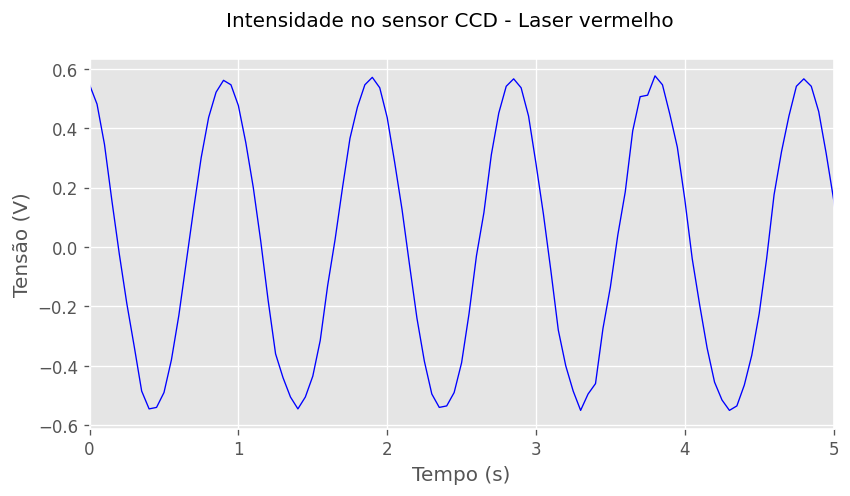

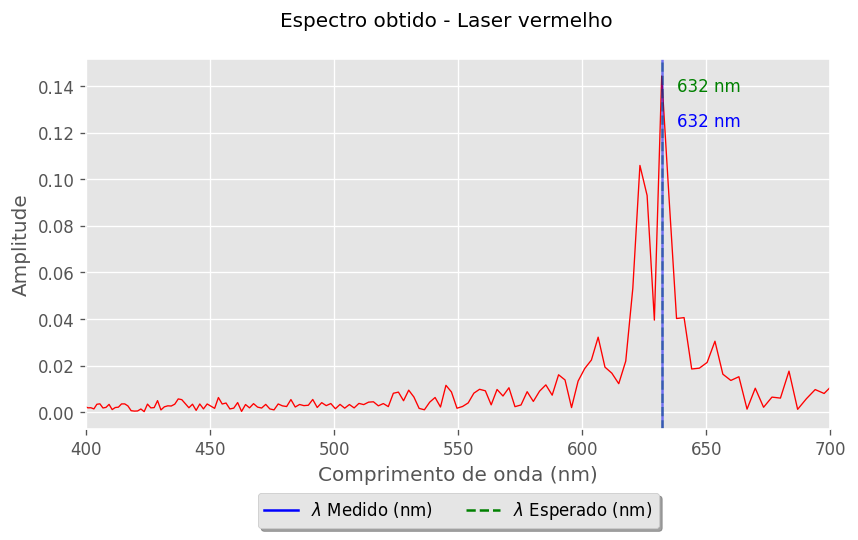

In [53]:
fig_tempo, fig_lambda = grafico("vermelho.csv",
                                lambda_esperados=[lambda_vermelho],
                                lambda_medidos=[tiny_interval(lambda_vermelho)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(700,'nm',0)])
fig_lambda.savefig("../resultados/lambda_vermelho.png")
fig_tempo.savefig("../resultados/tempo_vermelho.png")

## Verde

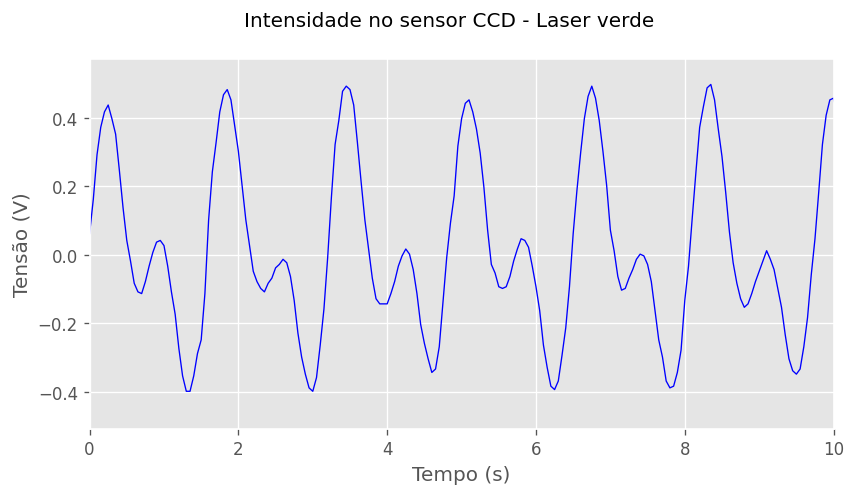

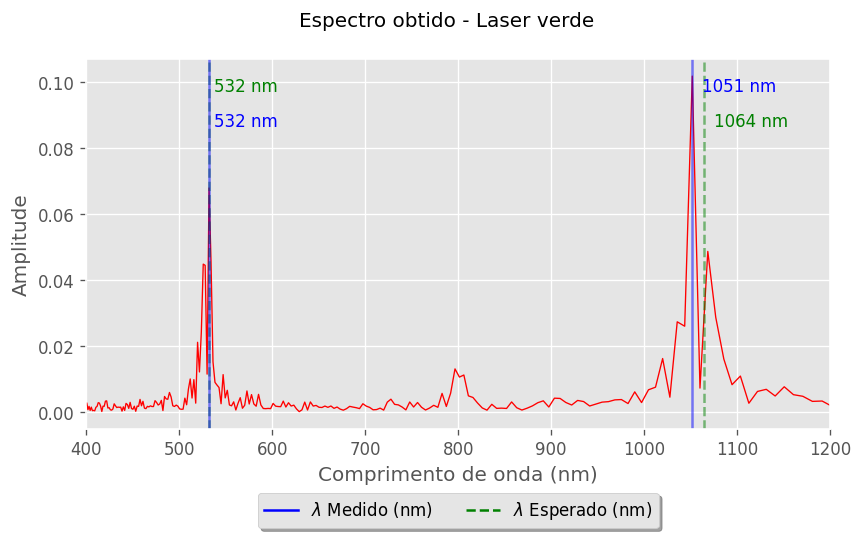

In [54]:
fig_tempo, fig_lambda = grafico("verde.csv",lambda_interval=[Medida(400,"nm",0),Medida(1200,'nm',0)],
                                time_interval=(Medida(0,"s",0),Medida(10,"s",0)),
                                lambda_medidos=[tiny_interval(lambda_verde),
                                                tiny_interval(lambda_verde_harmonico)],
                                lambda_esperados=[lambda_verde,lambda_verde_harmonico])
fig_tempo.savefig("../resultados/tempo_verde.png")
fig_lambda.savefig("../resultados/lambda_verde.png")

## Amarelo

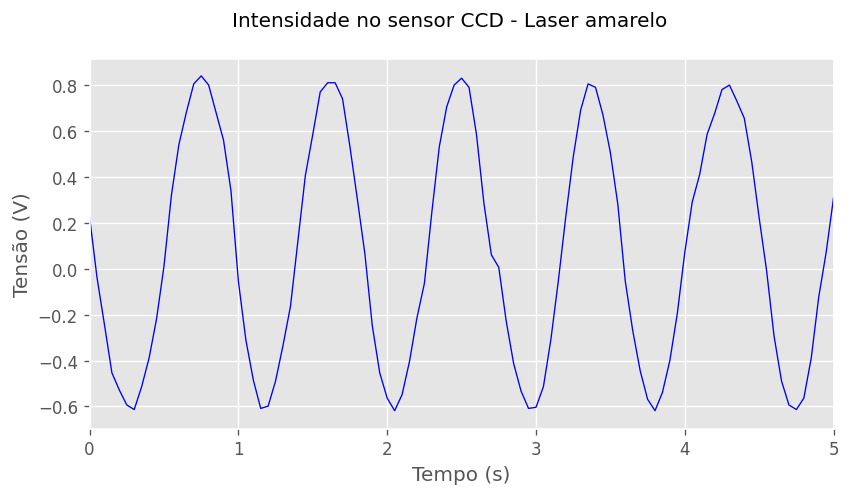

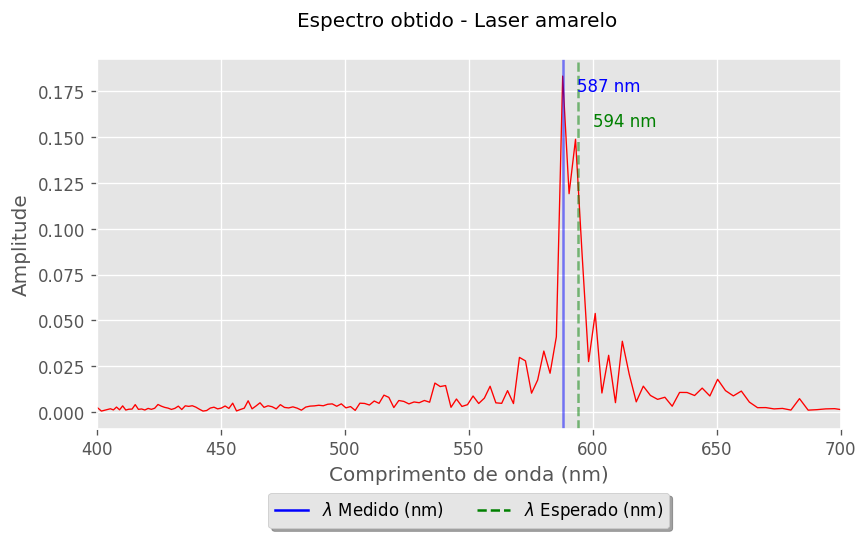

In [55]:
fig_tempo, fig_lambda = grafico("amarelo.csv",
                                lambda_esperados=[lambda_amarelo],
                                lambda_medidos=[tiny_interval(lambda_amarelo)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(700,'nm',0)])
fig_lambda.savefig("../resultados/lambda_amarelo.png")
fig_tempo.savefig("../resultados/tempo_amarelo.png")

## Vermelho +Verde

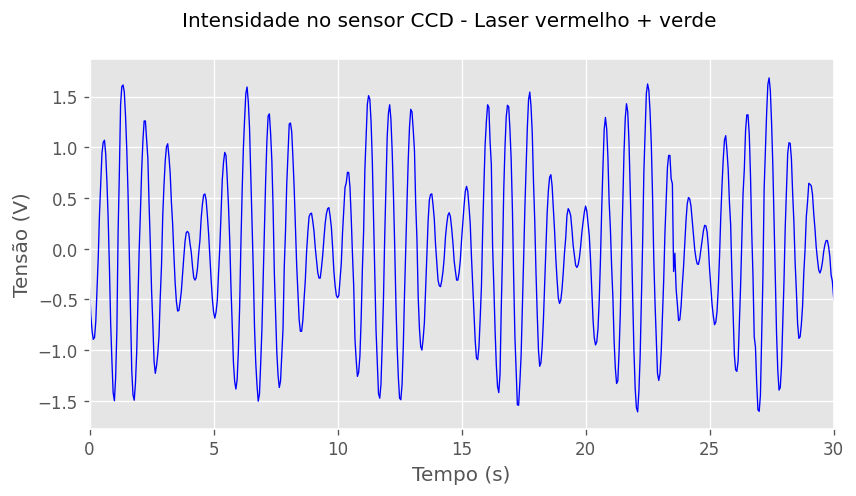

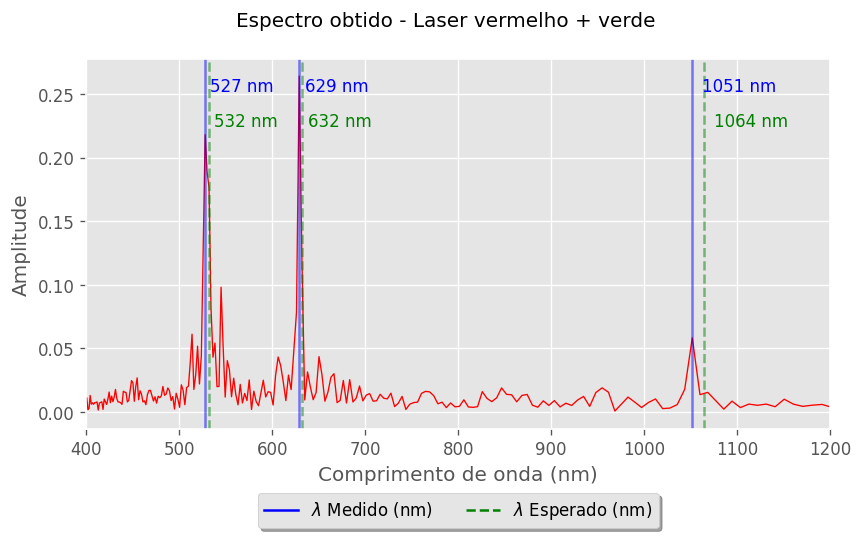

In [56]:
fig_tempo, fig_lambda = grafico("vermelho+verde.csv",
                                lambda_esperados=[lambda_vermelho,lambda_verde,lambda_verde_harmonico],
                                lambda_medidos=[tiny_interval(lambda_vermelho),
                                                tiny_interval(lambda_verde),
                                                tiny_interval(lambda_verde_harmonico)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(1200,'nm',0)],
                                time_interval=(Medida(0,"s",0),Medida(30,"s",0)))
fig_lambda.savefig("../resultados/lambda_vermelho_verde.png")
fig_tempo.savefig("../resultados/tempo_vermelho_verde.png")

## Vermelho + Amarelo

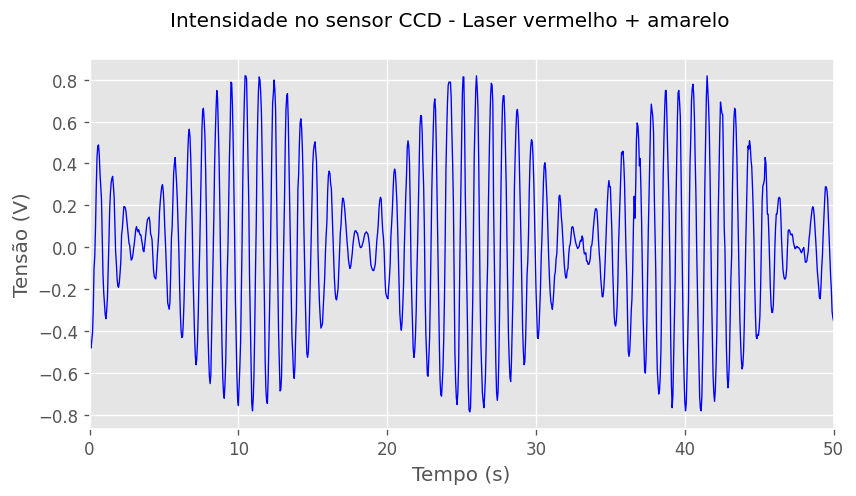

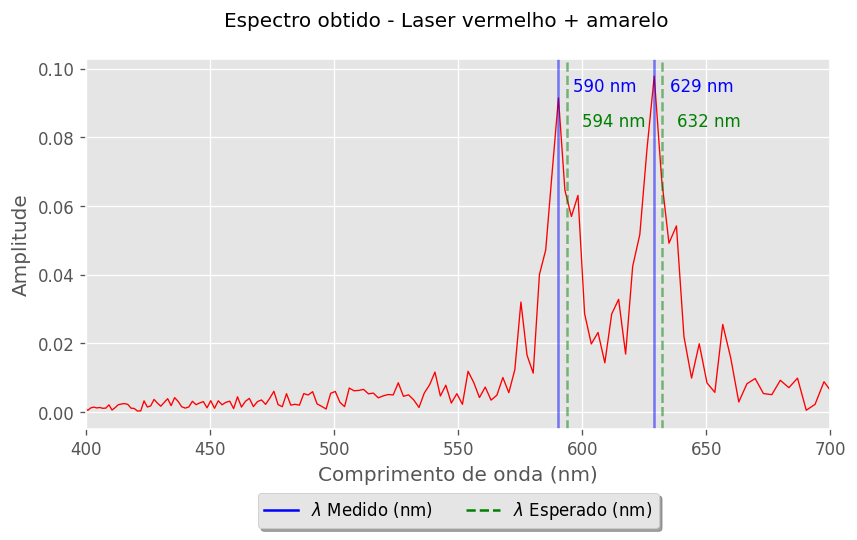

In [57]:
fig_tempo, fig_lambda = grafico("vermelho+amarelo.csv",
                                lambda_esperados=[lambda_vermelho,lambda_amarelo],
                                lambda_medidos=[tiny_interval(lambda_vermelho),
                                                tiny_interval(lambda_amarelo,0.02)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(700,'nm',0)],
                                time_interval=(Medida(0,"s",0),Medida(50,"s",0)))
fig_lambda.savefig("../resultados/lambda_vermelho_amarelo.png")
fig_tempo.savefig("../resultados/tempo_vermelho_amarelo.png")

## Amarelo + Verde

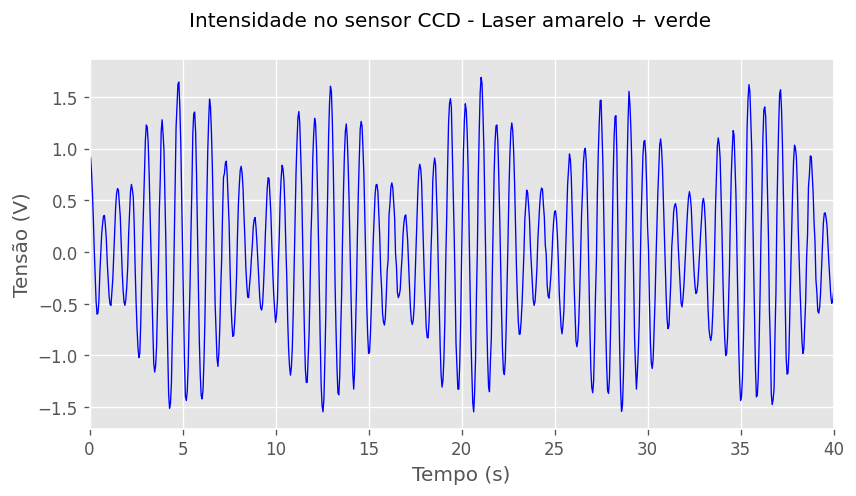

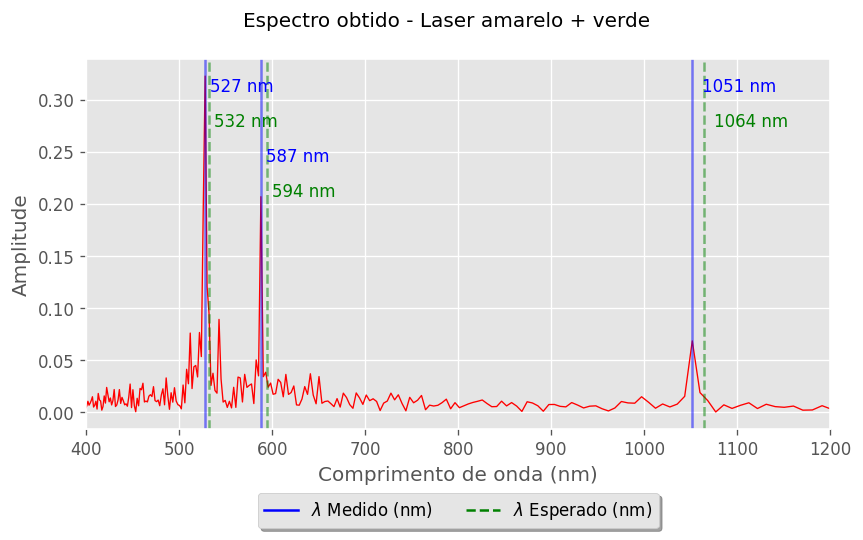

In [58]:
fig_tempo,fig_lambda = grafico("amarelo_verde.csv",lambda_esperados=[lambda_amarelo,lambda_verde,lambda_verde_harmonico], 
                    time_interval=(Medida(0,"s",0),Medida(40,"s",0)),lambda_interval=(Medida(400,"nm",0),Medida(1200,'nm',0)),
                    lambda_medidos=[tiny_interval(lambda_amarelo),
                                    tiny_interval(lambda_verde),
                                    tiny_interval(lambda_verde_harmonico)])
                       
fig_tempo.savefig("../resultados/tempo_amarelo_verde.png")
fig_lambda.savefig("../resultados/lambda_amarelo_verde.png")

## Vermelho + Verde

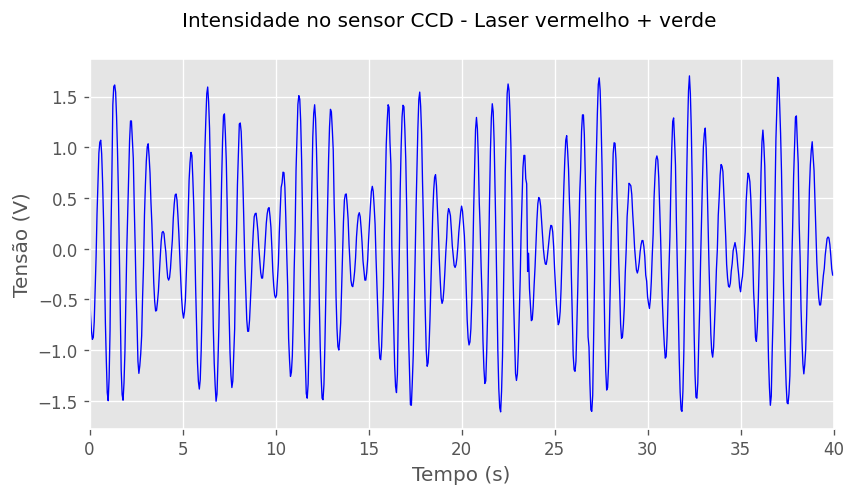

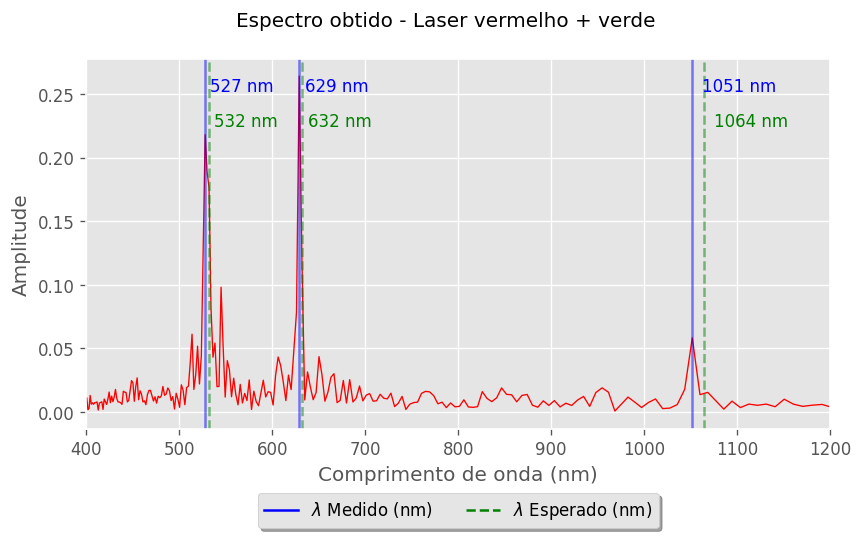

In [59]:
fig_tempo,fig_lambda = grafico("vermelho+verde.csv",lambda_esperados=[lambda_vermelho,lambda_verde,lambda_verde_harmonico], 
                    time_interval=(Medida(0,"s",0),Medida(40,"s",0)),lambda_interval=(Medida(400,"nm",0),Medida(1200,'nm',0)),
                    lambda_medidos=[tiny_interval(lambda_vermelho),
                                    tiny_interval(lambda_verde),
                                    tiny_interval(lambda_verde_harmonico)])
                       
fig_tempo.savefig("../resultados/tempo_vermelho_verde.png")
fig_lambda.savefig("../resultados/lambda_vermelho_verde.png")

## Vermelho + Verde + Amarelo

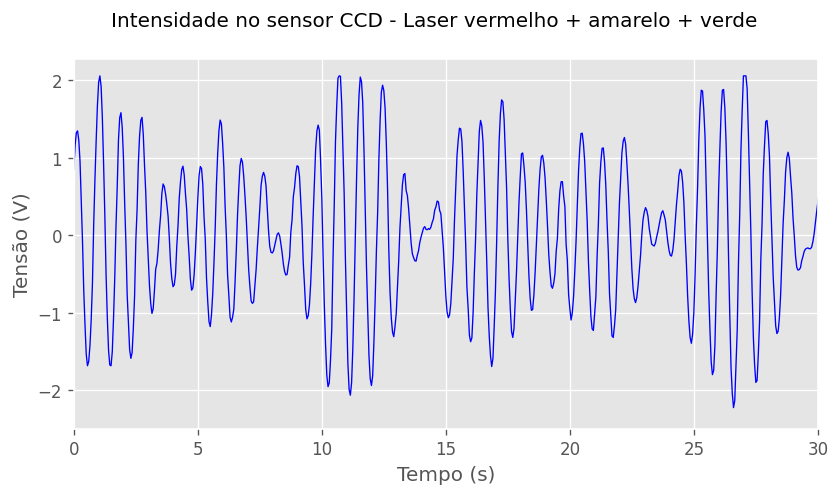

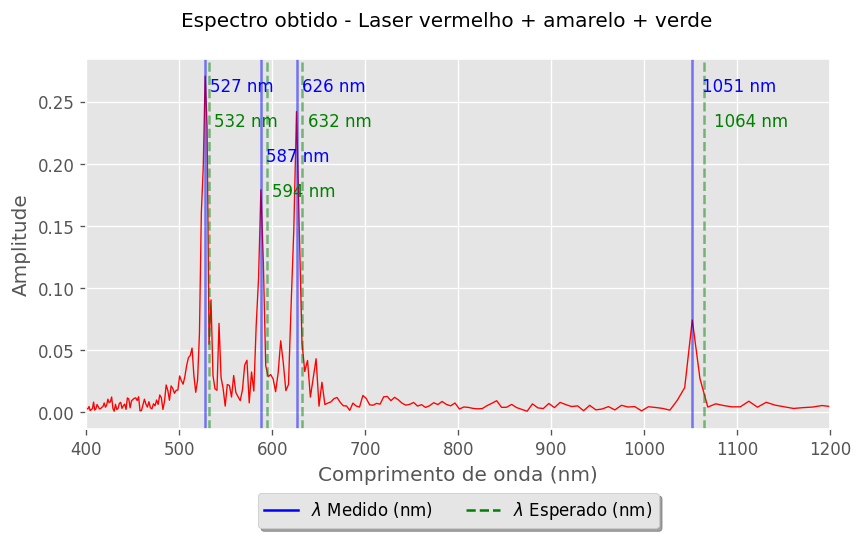

In [60]:
fig_tempo, fig_lambda = grafico("vermelho+amarelo+verde.csv", lambda_esperados=[lambda_vermelho,lambda_amarelo,lambda_verde,lambda_verde_harmonico],
                    lambda_medidos=[tiny_interval(lambda_vermelho),tiny_interval(lambda_amarelo,0.05),tiny_interval(lambda_verde),
                                    tiny_interval(lambda_verde_harmonico)],
                    time_interval=(Medida(0,"s",0),Medida(30,"s",0)),
                    lambda_interval=(Medida(400,"nm",0),Medida(1200,'nm',0)))
fig_lambda.savefig("../resultados/lambda_vermelho_amarelo_verde.png")
fig_tempo.savefig("../resultados/tempo_vermelho_amarelo_verde.png")